In [2]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import nlopt
from meep_material import lorentzfit

In [3]:
lambda_min = 0.4
lambda_max = 0.7
fmin = 1 / lambda_min
fmax = 1 / lambda_max
fcen = 0.5 * (fmin+fmax)
df = fmax - fmin
resolution = 200
nfreq = 25

In [4]:
def Material_fit(Material_data_csv=".", 
                   eps_inf=1,
                   fit_wl_min=0.38, fit_wl_max=0.72,
                   num_lorentzians=2, iteration=5
                   ):    

    # 1. 데이터 로드 및 전처리
    data = np.genfromtxt(Material_data_csv, delimiter=",")
    wl = data[:, 0] * 1e6  # 파장 (µm)
    n_data = data[:, 1] + 1j * data[:, 2]
    eps_all = np.square(n_data) - eps_inf

    # 피팅 범위로 데이터 선택
    mask = (wl >= fit_wl_min) & (wl <= fit_wl_max)
    wl_fit, eps_fit = wl[mask], eps_all[mask]
    freqs_fit = 1 / wl_fit

    # 2. Lorentzian 피팅 최적화
    ps = np.zeros((iteration, 3 * num_lorentzians))
    errors = np.zeros(iteration)
    for m in range(iteration):
        p_rand = [10 ** np.random.random() for _ in range(3 * num_lorentzians)]
        ps[m, :], errors[m] = lorentzfit(p_rand, freqs_fit, eps_fit, nlopt.LD_MMA, 1e-25, 50000)
        print(f"Iteration {m:3d}, error: {errors[m]:.6f}")
    best = np.argmin(errors)
    print(f"Optimal error: {errors[best]:.6f}")

    # 3. 최적 파라미터로 Susceptibility 생성 및 Meep 모델 구성
    suscept = []
    for i in range(num_lorentzians):
        freq_param = ps[best][3*i + 1]
        gamma = ps[best][3*i + 2]
        if freq_param == 0:
            sigma = ps[best][3*i + 0]
            suscept.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
        else:
            sigma = ps[best][3*i + 0] / freq_param**2
            suscept.append(mp.LorentzianSusceptibility(frequency=freq_param, gamma=gamma, sigma=sigma))

    return eps_inf, suscept

sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/SiO2/CSV/SiO2_palik_data.csv"
al_data_path = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/Al_Palik/CSV/Al_palik_data.csv"
andp_data_path = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/aNDP/CSV/aNPD_PFA_data.csv"

eps_inf_sio2, suscept_sio2 = Material_fit(Material_data_csv=sio2_data_path)
eps_inf_al, suscept_al = Material_fit(Material_data_csv=al_data_path)
eps_inf_andp, suscept_andp = Material_fit(Material_data_csv=andp_data_path)

Iteration   0, error: 0.000012
Iteration   1, error: 0.000021
Iteration   2, error: 0.000013
Iteration   3, error: 0.000015
Iteration   4, error: 0.000016
Optimal error: 0.000012
Iteration   0, error: 54.483567
Iteration   1, error: 64.226780
Iteration   2, error: 64.226780
Iteration   3, error: 64.226780
Iteration   4, error: 54.483567
Optimal error: 54.483567
Iteration   0, error: 0.032559
Iteration   1, error: 0.028183
Iteration   2, error: 0.028058
Iteration   3, error: 0.028701
Iteration   4, error: 0.028058
Optimal error: 0.028058


In [5]:
Glass = mp.Medium(epsilon=eps_inf_sio2, E_susceptibilities=suscept_sio2) # SiO2 
aNDP = mp.Medium(epsilon=eps_inf_andp, E_susceptibilities = suscept_andp) # aNDP 
Cathode = mp.Medium(epsilon=eps_inf_al, E_susceptibilities = suscept_al) # Al

In [6]:
### ----- Refractive index ----- ###
CoverLayer = mp.Medium(index=1.0) # SiN 
ITO = mp.Medium(index=1.8) 
Alq3 = mp.Medium(index=1.68) 
Air = mp.Medium(index=1.0) # 공기

In [7]:
Glass_layer = 1.37
Cover_layer = 0.07
ITO_layer = 0.15
aNDP_layer = 0.05
Alq3_layer = 0.06
Cathode_layer = 0.3

pml_layer = 0.3

print(Glass_layer+Cover_layer+Cathode_layer+aNDP_layer+ITO_layer+Alq3_layer)

2.0


In [8]:
# PML 경계조건
# boundary_layers = [mp.PML(pml_layer)] 

boundary_layers = [
    mp.PML(thickness=pml_layer, direction=mp.X, side=mp.Low),  # 좌측 PML
    mp.PML(thickness=pml_layer, direction=mp.X, side=mp.High), # 우측 PML
    mp.PML(thickness=pml_layer, direction=mp.Y, side=mp.High), # 상단 PML
]

In [9]:
geometry = [
    # Cathode (하단)
    mp.Block(
        center=mp.Vector3(0, -0.85, 0),
        size=mp.Vector3(30, Cathode_layer, 0),
        material=Cathode
    ),
    # Alq3
    mp.Block(
        center=mp.Vector3(0, -0.67, 0),
        size=mp.Vector3(30, Alq3_layer, 0),
        material=Alq3
    ),
    # aNDP
    mp.Block(
        center=mp.Vector3(0, -0.615, 0),
        size=mp.Vector3(30, aNDP_layer, 0),
        material=aNDP
    ),
    # ITO
    mp.Block(
        center=mp.Vector3(0, -0.515, 0),
        size=mp.Vector3(30, ITO_layer, 0),
        material=ITO
    ),
    # Cover layer
    mp.Block(
        center=mp.Vector3(0, -0.405, 0),
        size=mp.Vector3(30, Cover_layer, 0),
        material=CoverLayer
    ),
    # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
    mp.Block(
        center=mp.Vector3(0, 0.315, 0),
        size=mp.Vector3(30, Glass_layer, 0),
        material=Glass
    )
]

In [10]:
cell_size = mp.Vector3(30, 2, 0)

In [ ]:
# 1um 지점에 farfield 모니터
# dft monitor <-> field monitor

In [11]:
source_center = mp.Vector3(0,-0.67,0)
sources = [mp.Source(
    src=mp.GaussianSource(frequency=fcen, fwidth=df),
    component=mp.Ey,
    center=source_center
)]

In [12]:
# === 시뮬레이션 설정 === #
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

plt.figure(dpi=200)
plt.show()

<Figure size 1280x960 with 0 Axes>

     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0.315,0)
          size (30,1.37,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

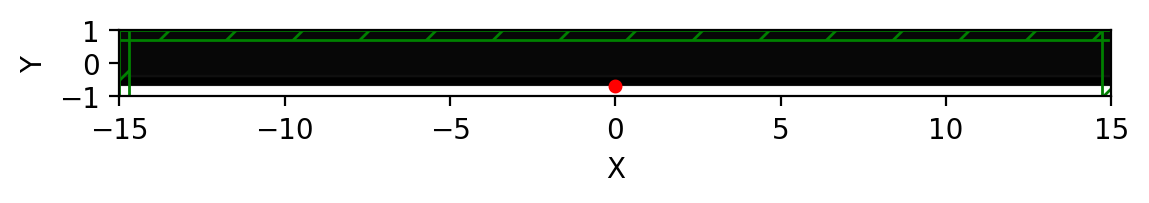

In [13]:
plt.figure(dpi = 200)
sim.plot2D()# output_plane=mp.Volume(center=mp.Vector3(y=0), size=mp.Vector3(Sx, 0, Sz)))

In [ ]:
flux_dist = 1.0  # dipole로부터 거리
flux_y1 = sim.add_flux(fcen, df, nfreq,
    mp.FluxRegion(center=mp.Vector3(0, source_center.y - flux_dist), direction=mp.Y, weight=-1))
flux_y2 = sim.add_flux(fcen, df, nfreq,
    mp.FluxRegion(center=mp.Vector3(0, source_center.y + flux_dist), direction=mp.Y))

# --- 시뮬레이션 실행 ---
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ey, source_center, 1e-6))

# --- flux 계산 ---
flux_total = mp.get_fluxes(flux_y1) + mp.get_fluxes(flux_y2)
frequencies = mp.get_flux_freqs(flux_y1)

# --- 출력 ---
print("frequency (1/μm)\tnet power")
for i in range(nfreq):
    print(f"{frequencies[i]:.4f}\t\t{flux_total[i]:.6f}")

In [ ]:
plt.show()